In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm  # 导入tqdm库
import warnings  # 避免一些可以忽略的报错
warnings.filterwarnings('ignore')  # 过滤警告信息
plt.rcParams['font.sans-serif'] = ['SimHei']  # 正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 加载数据
df = pd.read_csv("D:\\Documents\\cluener_public\\LSTM\MSFT(2000-2023).csv")
print(f"len(df): {len(df)}")    
df.head()


len(df): 6012


,Date,Open,High,Low,Close,Adj Close,Volume
0,1/3/2000,58.68750,59.3125,56.00000,58.28125,36.132248,53228400
1,1/4/2000,56.78125,58.5625,56.12500,56.31250,34.911709,54119000
2,1/5/2000,55.56250,58.1875,54.68750,56.90625,35.279816,64059600
3,1/6/2000,56.09375,56.9375,54.18750,55.00000,34.098019,54976600
4,1/7/2000,54.31250,56.1250,53.65625,55.71875,34.543629,62013600


In [4]:
df.shape

(6012, 7)

Close: 6012


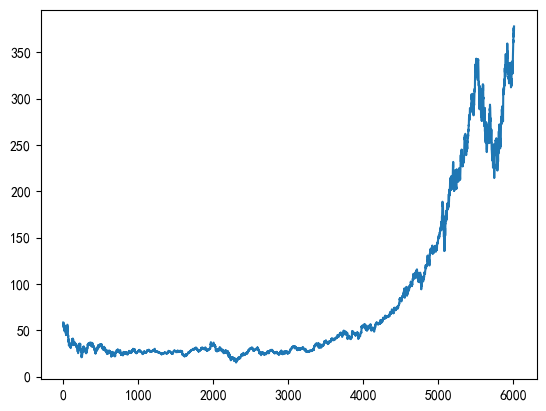

In [5]:
# 提取收盘价数据
Close = df['Close'].values
print(f"Close: {len(Close)}")        # Close:1511

# 绘制收盘价变化图
plt.plot([i for i in range(len(Close))], Close)

In [6]:
# 选择相关的列，数据列名为：['Date', 'Open', 'High', 'Low', 'Close']
df = df[['Date', 'Open', 'High', 'Low', 'Close']]

# 转换日期为日期类型
df['Date'] = pd.to_datetime(df['Date'])

# 使用 MinMaxScaler 归一化数据
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close']])

#### 第一部分：input_size = 4；也就是说用了Open、High、Low、Close四个特征

In [7]:

# 设置时间窗口 (Sequence Length)
seq_length = 3  # 过去3天的数据来预测当天的收盘价

# 数据划分函数
def split_data(data, seq_length):
    dataX = []
    datay = []
    for i in range(len(data)-seq_length):
        dataX.append(data[i:i+seq_length])
        datay.append(data[i+seq_length, 3])  # 收盘价是目标数据（归一化后对应第4列）
    dataX = np.array(dataX).reshape(len(dataX), seq_length, -1)
    datay = np.array(datay).reshape(len(dataX), -1)
    return np.array(dataX), np.array(datay)

# 创建数据集
dataX, datay = split_data(scaled_data, seq_length)
print(f"dataX.shape: {dataX.shape}, datay.shape: {datay.shape}")


dataX.shape: (6009, 3, 4), datay.shape: (6009, 1)


In [8]:
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(dataX, datay, test_size=0.2, shuffle=False)
print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(y_test, dtype=torch.float32)

# 打印训练集输入张量的形状
print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)

# 创建训练数据集和加载器
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# 创建测试数据集和加载器
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


X_train.shape: (4807, 3, 4), X_test.shape: (1202, 3, 4)
X_train:  torch.Size([4807, 3, 4])
Y_train:  torch.Size([4807, 1])


In [9]:
# LSTM 模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, output_size=1, num_layers=3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # 初始化记忆状态c0
        out, _ = self.lstm(x, (h0, c0))  # 仅返回最后一个时间步的输出
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        return out
    
# 初始化模型
model = LSTMModel(input_size=4, hidden_size=64, output_size=1, num_layers=1)


In [10]:
for x_train, y_train in train_loader:
    print(x_train.shape)
    print(y_train.shape)
    break

torch.Size([32, 3, 4])
torch.Size([32, 1])


In [11]:
# 训练模型
criterion = nn.MSELoss()  # 使用均方误差损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50  # 设置训练轮数
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    
    for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", ncols=100):
        x_train, y_train = x_train, y_train
        optimizer.zero_grad()  # 清空梯度
        y_train_pred = model(x_train)  # 模型预测
        loss = criterion(y_train_pred, y_train)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        
        running_train_loss += loss.item() * x_train.size(0)  # 累加训练损失
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # 验证集评估
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test, y_test
            y_test_pred = model(x_test)  # 模型预测
            loss = criterion(y_test_pred, y_test)  # 计算损失
            running_val_loss += loss.item() * x_test.size(0)  # 累加验证损失
    
    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


Epoch 45/50 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 338.00it/s]


Epoch 45/50, Train Loss: 0.0009, Validation Loss: 0.0108


Epoch 46/50 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 376.56it/s]


Epoch 46/50, Train Loss: 0.0011, Validation Loss: 0.0029


Epoch 47/50 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 350.35it/s]


Epoch 47/50, Train Loss: 0.0010, Validation Loss: 0.0054


Epoch 48/50 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 354.46it/s]


Epoch 48/50, Train Loss: 0.0012, Validation Loss: 0.0020


Epoch 49/50 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 321.96it/s]


Epoch 49/50, Train Loss: 0.0010, Validation Loss: 0.0019


Epoch 50/50 - Training: 100%|████████████████████████████████████| 151/151 [00:00<00:00, 354.39it/s]

Epoch 50/50, Train Loss: 0.0013, Validation Loss: 0.0048


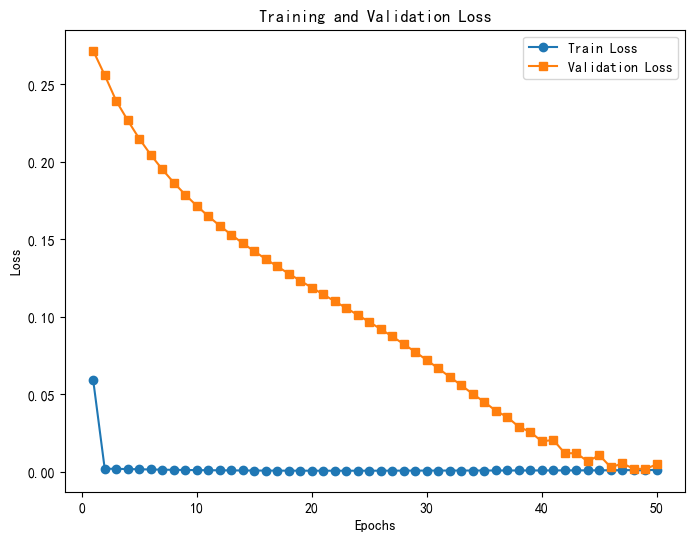

In [12]:
# 绘制训练和验证损失曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


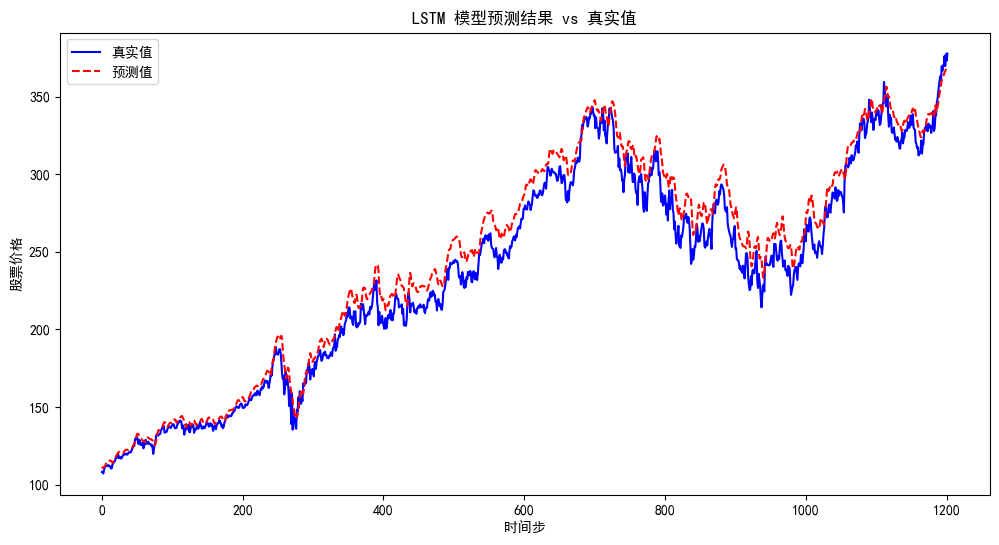

In [13]:

# 获取模型预测值并反归一化
predictions = model(X_test).detach().numpy().reshape(-1, 1)
real_values = Y_test.detach().numpy().reshape(-1, 1)

# 将 predictions 和 real_values 转换为 (302, 4) 的数组，填充前三列为零
predictions = np.column_stack([np.zeros((predictions.shape[0], 3)), predictions])  # 填充前三列为零
real_values = np.column_stack([np.zeros((real_values.shape[0], 3)), real_values])  # 填充前三列为零

# 反归一化
predictions = scaler.inverse_transform(predictions)[:, 3]  # 提取最后一列（即收盘价）
real_values = scaler.inverse_transform(real_values)[:, 3]  # 提取最后一列（即收盘价）

# 绘制预测结果与真实值
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='真实值', color='blue')
plt.plot(predictions, label='预测值', color='red', linestyle='dashed')
plt.xlabel('时间步')
plt.ylabel('股票价格')
plt.title('LSTM 模型预测结果 vs 真实值')
plt.legend()
plt.show()


#### 第二部分：input_size = 1；也就是说只用了Close这1个特征；对数据做了切片`df[["close"]]`

In [14]:
# 设置时间窗口 (Sequence Length)
seq_length = 3  # 过去3天的数据来预测当天的收盘价

# 数据划分函数
def split_data(data, seq_length):
    dataX = []
    datay = []
    for i in range(len(data)-seq_length):
        dataX.append(data[i:i+seq_length,3])  # 这个地方做了改动
        datay.append(data[i+seq_length, 3])
    dataX = np.array(dataX).reshape(len(dataX), seq_length, -1)
    datay = np.array(datay).reshape(len(dataX), -1)
    return np.array(dataX), np.array(datay)

# 创建数据集
dataX, datay = split_data(scaled_data, seq_length)
print(f"dataX.shape: {dataX.shape}, datay.shape: {datay.shape}")


dataX.shape: (6009, 3, 1), datay.shape: (6009, 1)


In [15]:
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(dataX, datay, test_size=0.2, shuffle=False)
print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(y_test, dtype=torch.float32)

# 打印训练集输入张量的形状
print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)

# 创建训练数据集和加载器
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# 创建测试数据集和加载器
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


X_train.shape: (4807, 3, 1), X_test.shape: (1202, 3, 1)
X_train:  torch.Size([4807, 3, 1])
Y_train:  torch.Size([4807, 1])


In [16]:
# LSTM 模型定义
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=3):  # 这个地方做了改动
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # 初始化记忆状态c0
        out, _ = self.lstm(x, (h0, c0))  # 仅返回最后一个时间步的输出
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        return out
    
# 初始化模型
model = LSTMModel(input_size=1, hidden_size=64, output_size=1, num_layers=1)  # 这个地方做了改动


In [17]:
for x_train, y_train in train_loader:
    print(x_train.shape)
    print(y_train.shape)
    break

torch.Size([32, 3, 1])
torch.Size([32, 1])


In [18]:
# 训练模型
criterion = nn.MSELoss()  # 使用均方误差损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100  # 设置训练轮数
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    
    for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", ncols=100):
        x_train, y_train = x_train, y_train
        optimizer.zero_grad()  # 清空梯度
        y_train_pred = model(x_train)  # 模型预测
        loss = criterion(y_train_pred, y_train)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        
        running_train_loss += loss.item() * x_train.size(0)  # 累加训练损失
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # 验证集评估
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test, y_test
            y_test_pred = model(x_test)  # 模型预测
            loss = criterion(y_test_pred, y_test)  # 计算损失
            running_val_loss += loss.item() * x_test.size(0)  # 累加验证损失
    
    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


Epoch 97/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 382.28it/s]


Epoch 97/100, Train Loss: 0.0019, Validation Loss: 0.0716


Epoch 98/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 341.62it/s]


Epoch 98/100, Train Loss: 0.0020, Validation Loss: 0.0578


Epoch 99/100 - Training: 100%|███████████████████████████████████| 151/151 [00:00<00:00, 375.62it/s]


Epoch 99/100, Train Loss: 0.0020, Validation Loss: 0.0496


Epoch 100/100 - Training: 100%|██████████████████████████████████| 151/151 [00:00<00:00, 355.29it/s]

Epoch 100/100, Train Loss: 0.0020, Validation Loss: 0.0388


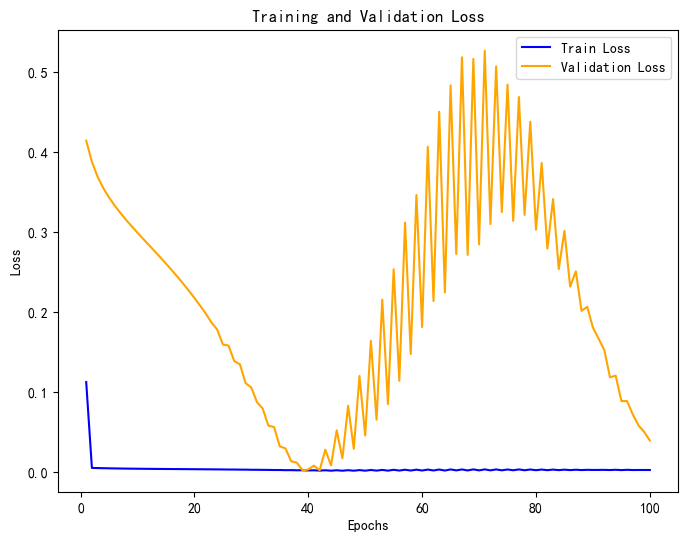

In [19]:
# 绘制训练和验证损失曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss',color = "blue")
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss',color = "orange")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training and Validation Loss')
plt.legend()


In [20]:

# 获取模型预测值并反归一化
predictions = model(X_test).detach().numpy().reshape(-1, 1)
real_values = Y_test.detach().numpy().reshape(-1, 1)

# 将 predictions 和 real_values 转换为 (302, 4) 的数组，填充前三列为零
predictions = np.column_stack([np.zeros((predictions.shape[0], 3)), predictions])  # 填充前三列为零
real_values = np.column_stack([np.zeros((real_values.shape[0], 3)), real_values])  # 填充前三列为零


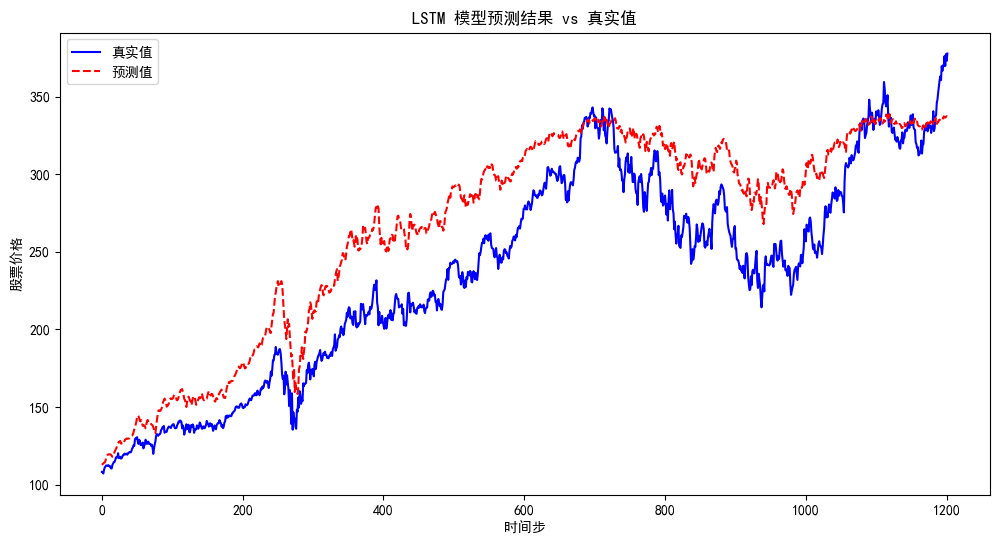

In [21]:

# 反归一化
predictions = scaler.inverse_transform(predictions)[:, 3]  # 提取最后一列（即收盘价）
real_values = scaler.inverse_transform(real_values)[:, 3]  # 提取最后一列（即收盘价）

# 绘制预测结果与真实值
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='真实值', color='blue')
plt.plot(predictions, label='预测值', color='red', linestyle='dashed')
plt.xlabel('时间步')
plt.ylabel('股票价格')
plt.title('LSTM 模型预测结果 vs 真实值')
plt.legend()
plt.show()
